## Tutorial: Recurrent neural networks for cognitive neuroscience

Creator: Guangyu Robert Yang

Contributors: Jenelle J Feather, Mahdi Fouad Ramadan, Ling Liang Dong, Fernanda De la Torre


Note: This tutorial can be used as a standalone tutorial for yourself. It is prepared for a 2h interactive session at MIT BCS.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/trendinafrica/Comp_Neuro-ML_course/blob/main/notebooks/15-Thursday/RNN_tutorial.ipynb)

For more details, you can check out [this talk](https://www.youtube.com/watch?v=Eq-chOIbOwM) or this [Primer](https://www.sciencedirect.com/science/article/abs/pii/S0896627320307054) (its [arxiv version](https://arxiv.org/abs/2006.01001)).

A seminal paper in this area that is a must-read is [Mante\*, Sussillo\*, Shenoy, Newsome 2013](https://www.nature.com/articles/nature12742).

### Installing and importing relevant packages

In [1]:
# If on Google Colab, uncomment to install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

Cloning into 'neurogym'...
remote: Enumerating objects: 10956, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 10956 (delta 69), reused 90 (delta 34), pack-reused 10827
Receiving objects: 100% (10956/10956), 8.16 MiB | 23.94 MiB/s, done.
Resolving deltas: 100% (8255/8255), done.
/content/neurogym
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
  Running setup.py develop for neurogym


In [2]:
# Import common packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

### Defining a recurrent neural network

**LSTM**: A typical recurrent network in machine learning. Usage example adopted from pytorch documentation.

In [3]:
import torch
import torch.nn as nn  # nn stands for neural network


# Make a LSTM, input_size is the dimension of inputs,
# hidden_size is the number of hidden neurons
rnn = nn.LSTM(input_size=10, hidden_size=20, num_layers=2)

# Generate some mock inputs
input = torch.randn(5, 3, 10)  # (Sequence Length, Batch Size, Input Size)
output, (hn, cn) = rnn(input)

print('Output shape is (SeqLen, BatchSize, HiddenSize):', output.shape)

Output shape is (SeqLen, BatchSize, HiddenSize): torch.Size([5, 3, 20])


In general, recurrent neural networks transform **sequence to sequence**. Other network architectures, such as MultiHeadAttetion as used in Transformers, can also be thought of as sequence to sequence. 

In the context of cognitive neuroscience, the sequence is usually a time series of task input or output.

In [4]:
input = torch.randn(5, 3, 10)  # (Sequence Length, Batch Size, Input Size)

lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=2)
output, _ = lstm(input)
print('Output shape is (SeqLen, BatchSize, Dimension):', output.shape)

rnn = nn.RNN(input_size=10, hidden_size=20, num_layers=2)
output, _ = rnn(input)
print('Output shape is (SeqLen, BatchSize, Dimension):', output.shape)

gru = nn.GRU(input_size=10, hidden_size=20, num_layers=2)
output, _ = gru(input)
print('Output shape is (SeqLen, BatchSize, Dimension):', output.shape)

mha = nn.MultiheadAttention(embed_dim=10, num_heads=1)
output, _ = mha(query=input, key=input, value=input)
print('Output shape is (SeqLen, BatchSize, Dimension):', output.shape)

Output shape is (SeqLen, BatchSize, Dimension): torch.Size([5, 3, 20])
Output shape is (SeqLen, BatchSize, Dimension): torch.Size([5, 3, 20])
Output shape is (SeqLen, BatchSize, Dimension): torch.Size([5, 3, 20])
Output shape is (SeqLen, BatchSize, Dimension): torch.Size([5, 3, 10])


Here we first define a continuous-time neural network,
\begin{align}
    \tau \frac{d\mathbf{r}}{dt} = -\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r).
\end{align}

Then we discretize this network in time using the Euler method with a time step of $\Delta t$, 
\begin{align}
    \mathbf{r}(t+\Delta t) = \mathbf{r}(t) + \Delta \mathbf{r} &= \mathbf{r}(t) + \frac{\Delta t}{\tau}[-\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r)] \\
    &= (1 - \frac{\Delta t}{\tau})\mathbf{r}(t) + \frac{\Delta t}{\tau}f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r)
\end{align}

In [5]:
# Define networks
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
    

class CTRNN(nn.Module):
    """Continuous-time RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms. 
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Continuous time RNN
        self.rnn = CTRNN(input_size, hidden_size, **kwargs)
        
        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

Similar to LSTM, CTRNN transform sequence to sequence

In [6]:
batch_size = 16
seq_len = 20  # sequence length
input_size = 5  # input dimension

# Make some random inputs
input_rnn = torch.rand(seq_len, batch_size, input_size)

# Make network
rnn = RNNNet(input_size=input_size, hidden_size=100, output_size=10)

# Run the sequence through the network
out, rnn_output = rnn(input_rnn)

print('Input of shape (SeqLen, BatchSize, InputDim)=', input_rnn.shape)
print('Output of shape (SeqLen, BatchSize, Neuron)=', out.shape)

Input of shape (SeqLen, BatchSize, InputDim)= torch.Size([20, 16, 5])
Output of shape (SeqLen, BatchSize, Neuron)= torch.Size([20, 16, 10])


### Defining a simple cognitive task

Here we use the neurogym package to make a simple "perceptual decision making" task.

In [16]:
import gym  # package for RL environments
import neurogym as ngym

# Canned environment from neurogym
task_name = 'PerceptualDecisionMaking-v0'
# Importantly, we set discretization time step for the task as well
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}

# Boilerplate gym
env = gym.make(task_name, **kwargs)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


(**Skip to Visualize Environment if first time reading**) If you prefer, you can copy the [source code](https://github.com/neurogym/neurogym/blob/master/neurogym/envs/perceptualdecisionmaking.py) of this task from neurogym, and customize it. You can create an environment directly from the source code.

In [17]:
from neurogym import spaces

class PerceptualDecisionMaking(ngym.TrialEnv):
    """Two-alternative forced choice task in which the subject has to
    integrate two stimuli to decide which one is higher on average.
    A noisy stimulus is shown during the stimulus period. The strength (
    coherence) of the stimulus is randomly sampled every trial. Because the
    stimulus is noisy, the agent is encouraged to integrate the stimulus
    over time.
    Args:
        cohs: list of float, coherence levels controlling the difficulty of
            the task
        sigma: float, input noise level
        dim_ring: int, dimension of ring input and output
    """
    metadata = {
        'paper_link': 'https://www.jneurosci.org/content/12/12/4745',
        'paper_name': '''The analysis of visual motion: a comparison of
        neuronal and psychophysical performance''',
        'tags': ['perceptual', 'two-alternative', 'supervised']
    }

    def __init__(self, dt=100, rewards=None, timing=None, cohs=None,
                 sigma=1.0, dim_ring=2):
        super().__init__(dt=dt)
        if cohs is None:
            self.cohs = np.array([0, 6.4, 12.8, 25.6, 51.2])
        else:
            self.cohs = cohs
        self.sigma = sigma / np.sqrt(self.dt)  # Input noise

        # Rewards
        self.rewards = {'abort': -0.1, 'correct': +1., 'fail': 0.}
        if rewards:
            self.rewards.update(rewards)

        self.timing = {
            'fixation': 100,
            'stimulus': 2000,
            'delay': 0,
            'decision': 100}
        if timing:
            self.timing.update(timing)

        self.abort = False

        self.theta = np.linspace(0, 2*np.pi, dim_ring+1)[:-1]
        self.choices = np.arange(dim_ring)

        name = {'fixation': 0, 'stimulus': range(1, dim_ring+1)}
        self.observation_space = spaces.Box(
            -np.inf, np.inf, shape=(1+dim_ring,), dtype=np.float32, name=name)
        name = {'fixation': 0, 'choice': range(1, dim_ring+1)}
        self.action_space = spaces.Discrete(1+dim_ring, name=name)

    def _new_trial(self, **kwargs):
        """
        new_trial() is called when a trial ends to generate the next trial.
        The following variables are created:
            durations, which stores the duration of the different periods (in
            the case of perceptualDecisionMaking: fixation, stimulus and
            decision periods)
            ground truth: correct response for the trial
            coh: stimulus coherence (evidence) for the trial
            obs: observation
        """
        # Trial info
        trial = {
            'ground_truth': self.rng.choice(self.choices),
            'coh': self.rng.choice(self.cohs),
        }
        trial.update(kwargs)

        coh = trial['coh']
        ground_truth = trial['ground_truth']
        stim_theta = self.theta[ground_truth]

        # Periods
        self.add_period(['fixation', 'stimulus', 'delay', 'decision'])

        # Observations
        self.add_ob(1, period=['fixation', 'stimulus', 'delay'], where='fixation')
        stim = np.cos(self.theta - stim_theta) * (coh/200) + 0.5
        self.add_ob(stim, 'stimulus', where='stimulus')
        self.add_randn(0, self.sigma, 'stimulus', where='stimulus')

        # Ground truth
        self.set_groundtruth(ground_truth, period='decision', where='choice')

        return trial

    def _step(self, action):
        """
        _step receives an action and returns:
            a new observation, obs
            reward associated with the action, reward
            a boolean variable indicating whether the experiment has end, done
            a dictionary with extra information:
                ground truth correct response, info['gt']
                boolean indicating the end of the trial, info['new_trial']
        """
        new_trial = False
        # rewards
        reward = 0
        gt = self.gt_now
        # observations
        if self.in_period('fixation'):
            if action != 0:  # action = 0 means fixating
                new_trial = self.abort
                reward += self.rewards['abort']
        elif self.in_period('decision'):
            if action != 0:
                new_trial = True
                if action == gt:
                    reward += self.rewards['correct']
                    self.performance = 1
                else:
                    reward += self.rewards['fail']

        return self.ob_now, reward, False, {'new_trial': new_trial, 'gt': gt}

# Create environment from source code
env2 = PerceptualDecisionMaking(**kwargs)

**Visualize the environment.**

The following function helps us visualize the environment. It shows from top 
1. observation that the network/agent receives, 
2. actions taken by a random agent and the ground-truth (when applicable), 
3. reward received by the agent (relevant for reinforcement learning), 
4. performance of the network (we'll re-compute this explicitly ourselves).

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/content/neurogym/neurogym/utils/plotting.py:129: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'ob': np.array(observations).astype(np.float),


Input size 3
Output size 3


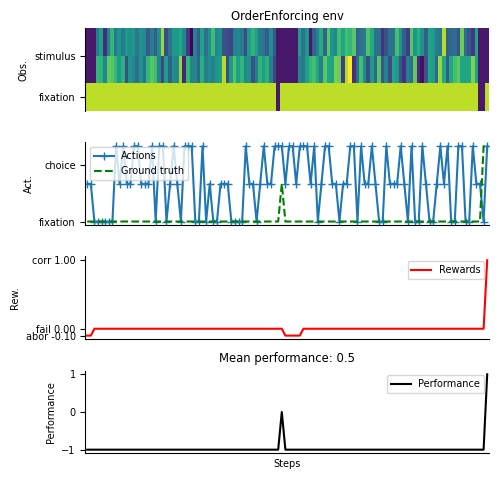

In [18]:
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# This is a simple task, the input and output are low-dimensional
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
print('Input size', input_size)
print('Output size', output_size)

For **supervised learning**, we need a dataset that returns (input, target output pairs).

In [19]:
# Make supervised dataset, neurogym boilerplate
seq_len = 100
batch_size = 16
dataset = ngym.Dataset(env, batch_size=batch_size, seq_len=seq_len)

# Generate one batch of data when called
inputs, target = dataset()
print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch) =', target.shape)
print('Target are the integers, for example target in the first sequence:')
print(target[:, 0])

Input has shape (SeqLen, Batch, Dim) = (100, 16, 3)
Target has shape (SeqLen, Batch) = (100, 16)
Target are the integers, for example target in the first sequence:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Training the network to perform the task

In [20]:
import torch.optim as optim
import time

# Instantiate the network and print information
hidden_size = 128
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
print(net)

def train_model(net, dataset):
    """Simple helper function to train the model.
    
    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair
    
    Returns:
        net: network object after training
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    running_loss = 0
    running_acc = 0
    start_time = time.time()
    # Loop over training batches
    print('Training network...')
    for i in range(1000):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output, _ = net(inputs)
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_loss, time.time() - start_time))
            running_loss = 0
    return net

net = train_model(net, dataset)

RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=3, out_features=128, bias=True)
    (h2h): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Training network...
Step 100, Loss 0.1842, Time 3.4s
Step 200, Loss 0.0734, Time 7.2s
Step 300, Loss 0.0562, Time 10.5s
Step 400, Loss 0.0428, Time 14.0s
Step 500, Loss 0.0370, Time 17.6s
Step 600, Loss 0.0349, Time 21.4s
Step 700, Loss 0.0272, Time 24.7s
Step 800, Loss 0.0281, Time 28.1s
Step 900, Loss 0.0296, Time 32.1s
Step 1000, Loss 0.0282, Time 35.4s


### Run the network after training, record activity, compute performance

Here we run the network after training. We could have used similar functions as we did in the `train_model` function. But instead we will explicitly loop through individual trials, so we can log the information and compute the performance of each trial.

In [21]:
import numpy as np
# Reset environment
env = dataset.env
env.reset(no_step=True)

# Initialize variables for logging
perf = 0
activity_dict = {}  # recording activity
trial_infos = {}  # recording trial information

num_trial = 200
for i in range(num_trial):
    # Neurogym boiler plate
    # Sample a new trial
    trial_info = env.new_trial()
    # Observation and groud-truth of this trial
    ob, gt = env.ob, env.gt
    # Convert to numpy, add batch dimension to input
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    
    # Run the network for one trial
    # inputs (SeqLen, Batch, InputSize)
    # action_pred (SeqLen, Batch, OutputSize)
    action_pred, rnn_activity = net(inputs)
    
    # Compute performance
    # First convert back to numpy
    action_pred = action_pred.detach().numpy()[:, 0, :]
    # Read out final choice at last time step
    choice = np.argmax(action_pred[-1, :])
    # Compare to ground truth
    correct = choice == gt[-1]
    
    # Record activity, trial information, choice, correctness
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    trial_infos[i] = trial_info  # trial_info is a dictionary
    trial_infos[i].update({'correct': correct})

# Print informations for sample trials
for i in range(5):
    print('Trial ', i, trial_infos[i])
    
print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

Trial  0 {'ground_truth': 0, 'coh': 25.6, 'correct': True}
Trial  1 {'ground_truth': 0, 'coh': 12.8, 'correct': True}
Trial  2 {'ground_truth': 0, 'coh': 6.4, 'correct': True}
Trial  3 {'ground_truth': 1, 'coh': 0.0, 'correct': False}
Trial  4 {'ground_truth': 1, 'coh': 25.6, 'correct': True}
Average performance 0.87


### Plot the network's activity in PCA

Next we will analyze the network by plotting its activity in PCA space. Each trajectory in the PC-space would correspond to a single trial.

In [22]:
# Apply PCA, boilerplate sklearn
from sklearn.decomposition import PCA

# Concatenate activity for PCA
activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)

pca = PCA(n_components=2)
pca.fit(activity)  # activity (Time points, Neurons)
activity_pc = pca.transform(activity)  # transform to low-dimension
print('Shape of the projected activity: (Time points, PCs): ', activity_pc.shape)

Shape of the neural activity: (Time points, Neurons):  (12000, 128)
Shape of the projected activity: (Time points, PCs):  (12000, 2)


Text(0, 0.5, 'PC 2')

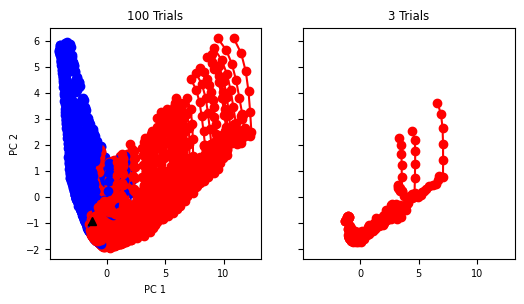

In [27]:
# Project each trial and visualize activity

import matplotlib.pyplot as plt

# Plot all trials in ax1, plot fewer trials in ax2
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))

for i in range(100):
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[i])  # (Time points, PCs)

    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'
    
    _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    if i < 3:
        _ = ax2.plot(activity_pc[:, 
                                 0], activity_pc[:, 1], 'o-', color=color)
        
    # Plot the beginning of a trial with a special symbol
    _ = ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

ax1.set_title('{:d} Trials'.format(100))
ax2.set_title('{:d} Trials'.format(3))
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

### Exercises

In the following section, we have 9 exercises, separated into 3 categories: Easy, Medium, Hard. 

Ideally, each exercise should take no more than 1 hour. If you are spending a long time on one exercise, consider choosing one that is easier.

### Exercise 1: Time constant of RNNs

**Easy** | Medium | Hard

Change the time constant of network units from 100ms to 40ms, and re-train the network. How does the final performance change?

What about changing the discretization time step from 20ms to 10ms, while keeping the time constant at 100ms?

### Exercise 2: Plot the performance of RNN during training

**Easy** | Medium | Hard

Plot the performance of the task during the training process. Generate a plot with x-axis training steps, and y-axis performance.

Hint: You can re-use the performance computing code from above.

### Exercise 3: Change the initialization of the RNN

**Easy** | Medium | Hard

Right now the RNN is initialized with the default pytorch initialization. Set instead the initial recurrent weight to an identity matrix. How does that influence the final performance?

Hint: You can plot the current initialization of the recurrent weight using the following code block.

Shape of RNN recurrent weight is  torch.Size([100, 100])


Text(0.5, 1.0, 'RNN weight at initialization')

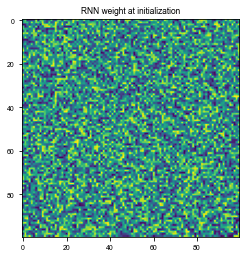

In [ ]:
# Make network
rnn = CTRNN(input_size=3, hidden_size=100)
print('Shape of RNN recurrent weight is ', rnn.h2h.weight.shape)

# Convert pytorch tensor to numpy array, pytorch boilerplate
weight = rnn.h2h.weight.detach().numpy()

plt.imshow(weight)
plt.title('RNN weight at initialization')

### Exercise 4: Hierarchical RNNs

Easy | **Medium** | Hard

Make a hierarhical RNN, where the first module receives external input, the second module receives inputs from the first and project to the third module. The third module produces the outputs.

Train this hierarhical RNN on the task.

(Optional) Visualize the activity on each module.

### Exercise 5: Sequential training of tasks

Easy | **Medium** | Hard

First train the network on one task, then train the network on the second task. Plot the performance of both tasks during the training process (see Exercise 2).

Hint: you can get many tasks with the same input and output format using the yang19 collection in neurogym. Get the name of all tasks by running:

`print(ngym.get_collection('yang19'))`

### Exercise 6: Training only output connections

Easy | **Medium** | Hard

Train only the output connections of the network, and plot performance. Compare performance with networks that have all weights trained.

### Exercise 7: Training spatially embedded RNNs

Easy | Medium | **Hard**

In normal neural networks, RNN units have no spatial locations. Assume that the RNN units are embedded in a 2-D cortical sheet, and it is more costly to have long-range connections. Train such spatially embedded RNNs and show that this influences the connectivity structure after training.

Hint: Several functions you want to consider writing:
1. Assigning network units spatial locations
2. Define a (differentiable) loss that depends on the connection weight from one neuron to another and their spatial distance.
3. Add this loss to the the training loss
4. Visualize connectivity matrix with and without the long-distance loss.

### Exercise 8: ConvNet + RNN

Easy | Medium | **Hard**

Design your own task or use the following task that provides image input at each time point. Add a convolutional network as the sensory module. No need to train the convolutional network.

Optional: Use a small pre-trained convolutional network.

In [ ]:
# A simple image based decision making task for this tutorial

class SimpleVisualDecisionMaking(ngym.TrialEnv):
    """Two-alternative forced choice task in which the subject has to
    integrate two stimuli to decide whether there is a horizontal or vertical bar.
    
    During a fixation period, a square is shown without noise. Then during
    the stimulus period, a horizontal or vertical bar is shown with noise. Then during
    the decision period, no stimulus is shown and the network should make a decision.

    Args:
        sigma: float, input noise level
    """

    def __init__(self, dt=100, rewards=None, timing=None, sigma=1.0):
        super().__init__(dt=dt)
        # Rewards
        self.rewards = {'abort': -0.1, 'correct': +1., 'fail': 0.}
        if rewards:
            self.rewards.update(rewards)

        self.timing = {
            'fixation': 100,
            'stimulus': 300,
            'decision': 100}
        if timing:
            self.timing.update(timing)

        self.sigma = sigma
            
        self.abort = False
        
        # Box shape (Channel, Height, Width)
        self.ob_shape = (1, 10, 10)
        self.observation_space = spaces.Box(
            -np.inf, np.inf, shape=self.ob_shape, dtype=np.float32)
        name = {'fixation': 0, 'choice': [1, 2]}
        self.action_space = spaces.Discrete(3, name=name)

    def _new_trial(self, **kwargs):
        # Trial info
        trial = {
            'ground_truth': self.rng.choice([0, 1]),
        }
        trial.update(kwargs)

        ground_truth = trial['ground_truth']

        # Periods
        self.add_period(['fixation', 'stimulus', 'decision'])

        # Observations
        im = np.zeros(self.ob_shape)
        im[0, 4:6, 4:6] = 1
        self.add_ob(im, period='fixation')
        
        im = np.zeros(self.ob_shape)
        if ground_truth == 0:
            im[0, 2:8, 4:6] = 1
        else:
            im[0, 4:6, 2:8] = 1
        self.add_ob(im, period='stimulus')
        self.add_randn(0, self.sigma, period='stimulus')

        # Ground truth
        self.set_groundtruth(ground_truth, period='decision', where='choice')

        return trial

    def _step(self, action):
        """
        _step receives an action and returns:
            a new observation, obs
            reward associated with the action, reward
            a boolean variable indicating whether the experiment has end, done
            a dictionary with extra information:
                ground truth correct response, info['gt']
                boolean indicating the end of the trial, info['new_trial']
        """
        new_trial = False
        # rewards
        reward = 0
        gt = self.gt_now
        # observations
        if self.in_period('fixation'):
            if action != 0:  # action = 0 means fixating
                new_trial = self.abort
                reward += self.rewards['abort']
        elif self.in_period('decision'):
            if action != 0:
                new_trial = True
                if action == gt:
                    reward += self.rewards['correct']
                    self.performance = 1
                else:
                    reward += self.rewards['fail']

        return self.ob_now, reward, False, {'new_trial': new_trial, 'gt': gt}

Visualize the environment

`sigma` adjusts the noise level. If you use `sigma=0`, you will see the horizontal or vertical bar clearly. Set `sigma=1` or higher to challenge the network and require it to use recurrent connections for integration.

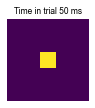

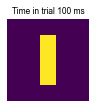

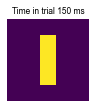

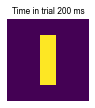

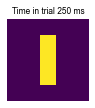

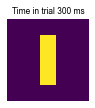

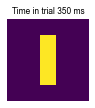

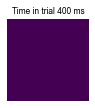

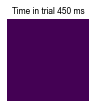

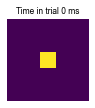

In [ ]:
# Create environment from source code
vis_env = SimpleVisualDecisionMaking(dt=50, sigma=0.0)

vis_env.reset(no_step=True)
# Loop through several time steps
for i in range(10):
    ob, _, _, _ = vis_env.step(action=0)  # keep choosing action 0
    
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(ob[0])
    plt.title('Time in trial {:d} ms'.format(vis_env.t))
    plt.axis('off')
    plt.show()

### Exercise 9: Short-term plasticity in RNN

Easy | Medium | **Hard**

Implement short-term plasticity in RNN and train the network on a working memory task. Compare the PCA trajectory with or without short-term plasticity.

More details on short-term plasticity below.

You can get a working memory task from `neurogym` by running `env = gym.make('DelayComparison-v0')`.

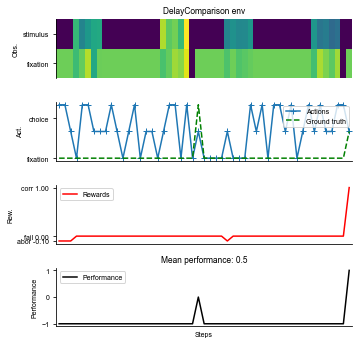

In [ ]:
env = gym.make('DelayComparison-v0')
_ = ngym.utils.plot_env(env, num_trials=2)

One way to implement **short-term plasticity for rate networks** is to adapt the model from [Mongillo, Barak, Tsodyks 2008](https://science.sciencemag.org/content/319/5869/1543). See [Masse et al. 2019](https://www.nature.com/articles/s41593-019-0414-3) for more details.

We assume that all output connection weights from a single neuron with activity $r(t)$ is being modulated by two scalar terms $x(t)$ and $u(t)$. 

$x(t)$ represents the neurotransmitter availability. It decreases with high activity $r(t)$ and gradually relaxes back to 1 when $r(t)=0$.

$\frac{dx(t)}{dt}=\frac{1-x(t)}{\tau_x} - u(t)x(t)r(t)$

$u(t)$ represents neurotransmitter utilization which increases towards 1 with high activity $r(t)$ and relaxs back to $U<1$ when there is no activity.

$\frac{du(t)}{dt}=\frac{U-u(t)}{\tau_u} - U(1-u(t))r(t)$

The input from the $i-$th neuron to the $j-$th neuron is therefore
$W_{i\rightarrow j}r_i(t) x_i(t) u_i(t)$

Set $\tau_x=200$ms, $\tau_u=1500$ms, $U=0.15$ for a facilitating synapse.

Set $\tau_x=1500$ms, $\tau_u=200$ms, $U=0.45$ for a depressing synapse.

These equations can be discretized in time with discretization step $\Delta t$ as

$\Delta x(t)=(1-x(t))\frac{\Delta t}{\tau_x} - u(t)x(t)r(t) \Delta t$

$\Delta u(t)=(U-u(t))\frac{\Delta t}{\tau_u} - U(1-u(t))r(t)\Delta t$

Hint: Start by making all synapses facilitating.